# GA Final Project DS Component

In our data exploration component we discovered that bluezone deaths are disproportionately high in Pochinki and Yasnaya Polyana as opposed to the rest of the map. Can we make any interesting discoveries using the aggregate stats of the players that died to the bluezone?

It looks like all our match data is based on Third Person Perspective (tpp), so it will likely only be relevant to that game-mode. Of course, our data ONLY pertains to single player matches.

This portion of the project will explore three main types of ML Analysis:

    1) Logistic Regression
    2) Kmeans Clustering
    3) Random Forest/Decision Trees

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

%matplotlib inline

In [2]:
direc = 'C:/Users/Jacek/Documents/GA/PUGB\\'

In [3]:
player_data = pd.read_csv(direc + 'GA_final_proj_data.csv')
pk_weap_data = pd.read_csv(direc + 'Pochinki_weapon_data.csv')
ys_weap_data = pd.read_csv(direc + 'Yasnaya_weapon_data.csv')

In [4]:
pk_weap_data.columns

Index(['Unnamed: 0', 'killed_by', 'deaths_PK', 'deaths_E', 'ratio_deaths_PK',
       'bz_risk', 'pktot_ratio', 'RR', 'log_RR', 'PK_to_E_deathratio',
       'pkpred_deaths', 'weap_risk_pk', 'weap_riskreal_pk'],
      dtype='object')

### Should only take stats for BZ risks

In [5]:
pk_weap_data.head()

Unnamed: 0 killed_by  deaths_PK  deaths_E  ratio_deaths_PK   bz_risk  \
0           0      M416        119     28117         0.004232  0.390508   
1           1    SCAR-L         85     19561         0.004345  0.400941   
2           2  Bluezone         82      7566         0.010838  1.000000   
3           3       AKM         34      7948         0.004278  0.394706   
4           4     M16A4         32      9527         0.003359  0.309918   

   pktot_ratio        RR    log_RR  PK_to_E_deathratio  pkpred_deaths  \
0     0.263858  0.001117 -6.797350            0.004375     123.013921   
1     0.188470  0.000819 -7.107458            0.004375      85.580798   
2     0.181818  0.001971 -6.229449            0.004375      33.101800   
3     0.075388  0.000322 -8.039422            0.004375      34.773078   
4     0.070953  0.000238 -8.341881            0.004375      41.681318   

   weap_risk_pk  weap_riskreal_pk  
0      0.967370          0.255248  
1      0.993213          0.187191  
2      2.477207          0.450401  
3      0.977768          0.073712  
4      0.767730          0.054473

In [36]:
pk_weap_data = pk_weap_data[pk_weap_data['killed_by']=='Bluezone']
ys_weap_data = ys_weap_data[ys_weap_data['killed_by']=='Bluezone']
ys_weap_data

Unnamed: 0 killed_by  deaths_YS  deaths_E  ratio_deaths_YS  ysbz_risk  \
1           1  Bluezone        141      7566         0.018636   3.609296   

   ystot_ratio      ysRR  log_ysRR  YS_to_E_deathratio  yspred_deaths_ys  \
1     0.210762  0.003928 -5.539684             0.00649         49.102227   

   weap_risk_ys  weap_riskreal_ys  
1       2.87156          0.605217

In [6]:
player_data_clean = player_data.drop(['Unnamed: 0','party_size','date','match_mode',
                       'player_dbno','killer_placement',
                       'killer_name','killer_position_x',
                       'killer_position_y','map',
                       'victim_placement'],axis=1).set_index('match_id')
pk_data_clean = pk_weap_data.drop(['Unnamed: 0','deaths_E'],axis=1).set_index('killed_by')

ys_data_clean = ys_weap_data.drop(['Unnamed: 0','deaths_E'],axis=1).set_index('killed_by')

In [7]:
#let's add the coordinates back in for the map we used in our initial analysis. This will help us ID death locations
player_data_clean['map_x'] = player_data_clean['victim_position_x']*4096/800000
player_data_clean['map_y'] = player_data_clean['victim_position_y']*4096/800000

### Aggro Factor

We need to have some quantifiable way to differentiate aggressive vs non-aggresive players. In a PUBG match, one is typically running and hiding while generally shying away from a fight OR searching for every opportunity for action. I'm going to create a proxy that assumes an aggressive player will have a higher impact on the rest of the players in the server. 

I'll set this up as the following:

<font color='blue'>$ {((kills + assists) } \div { game\_size)} \times {player\_damage} = {aggro\_factor}$</font>

In [8]:
player_data_clean['aggro_factor'] = ((player_data_clean['player_assists'] + player_data_clean['player_kills'])/player_data_clean['game_size']) * player_data_clean['player_dmg']

In [9]:
player_data_clean.reset_index(inplace=True)

In [10]:
player_data_clean.tail()

match_id  game_size  \
102950  2U4GBNA0Ymkq9C4T_GhKh7VdeBhTygHmYK34tVlu2j84Fd...         95   
102951  2U4GBNA0YmkF8JGozgXGWDMw6P4siTyIYFqpE_VXTdTE4n...         79   
102952  2U4GBNA0YmmTXtDYMzm14IOAaoeTab7ifi-kGqTDyJp8gk...         95   
102953  2U4GBNA0Ymkr1ExDD2gYt2_6MF5MvHzuCyagmf_2LrOLQg...         90   
102954  2U4GBNA0YmnlZ0EgyTeuEBBnuJ6dxGZZHYrrzQeE05dkRJ...         80   

        player_assists  player_dist_ride  player_dist_walk  player_dmg  \
102950               0        1236.01200        1798.29285         533   
102951               0        1428.00684        6351.81500         341   
102952               0         852.56060        3775.58179         693   
102953               1        1158.58500        3323.07500         499   
102954               1        2978.09400        2215.34082         324   

        player_kills  player_name  player_survive_time  team_id  \
102950             4      rnshwls             1979.444   100096   
102951             3      JR-chao             1938.365   100088   
102952             6    StegoRawr             1981.311   100019   
102953             5    DaGeGe886             1950.418   100016   
102954             3  DaddyBryant             1568.857   100081   

        team_placement killed_by  time  victim_name  victim_position_x  \
102950               2     M16A4  1979      rnshwls           440750.6   
102951               2    SCAR-L  1939      JR-chao           239341.8   
102952               2       AKM  1982    StegoRawr           360098.9   
102953               2      M416  1950    DaGeGe886           492880.2   
102954               2    Kar98k  1568  DaddyBryant           273800.0   

        victim_position_y        map_x        map_y  aggro_factor  
102950           446565.3  2256.643072  2286.414336     22.442105  
102951           125142.6  1225.430016   640.730112     12.949367  
102952           313173.2  1843.706368  1603.446784     43.768421  
102953           568322.3  2523.546624  2909.810176     33.266667  
102954           291958.9  1401.856000  1494.829568     16.200000

In [11]:
#Looks like we may have some cheating going on... we should analyze those players and remove them from the study
np.log(player_data_clean['aggro_factor']).describe()

C:\Users\Jacek\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


count    1.029550e+05
mean             -inf
std               NaN
min              -inf
25%      1.427116e+00
50%      2.506184e+00
75%      3.392387e+00
max      7.681001e+00
Name: aggro_factor, dtype: float64

### Hackers...

Let's create a way to see if someone is moving faster on foot than what the game dynamics are supposed to allow. If that's the case, they're probably a hacker!

| Variable | Speed | Comparison |
---| ---|---
| Unarmed | 6.3 m/s | Baseline |
| Pistol | 6.32 m/s | 0.3% Faster |
| Melee | 6.3 m/s | 0.1% Slower |
| Throwables | 6.29 m/s | 0.1% Slower |
| Submachine Guns | 6.15 m/s | 2.3% Slower |
| Crossbow | 6.01 m/s | 4.51% Slower |
| Rifle | 6.01 m/s | 4.60% Slower |
| Sniper Rifle/DMR | 5.99 m/s | 4.80% Slower |
| Shotgun | 5.91 m/s | 6.11% Slower |

From: https://pubg.gamepedia.com/Movement_Speed

In [46]:
player_data_clean['max_distance'] = player_data_clean['player_survive_time']*6.32 #max m/s * total match time
player_data_clean['speed_hacker'] = player_data_clean['player_dist_walk'] > (player_data_clean['max_distance']+1)

#player_data_clean = player_data_clean.reset_index()

data_nohax = player_data_clean[player_data_clean['speed_hacker'] != True]
data_nohax.drop(['team_id','match_id','player_dist_ride','victim_name','team_placement','speed_hacker','max_distance'],axis=1,inplace=True)
data_nohax['bz_death'] = np.where(data_nohax['killed_by'] == 'Bluezone', 1, 0)
data_nohax['merge'] = 0
data_nohax['bz_city_overall'] =0.1451
data_nohax.head()

C:\Users\Jacek\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Jacek\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Jacek\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main

game_size  player_assists  player_dist_walk  player_dmg  player_kills  \
0         91               1        1813.36450         186             0   
1         94               0        1287.92285         217             1   
2         95               0        2403.10352          52             0   
3         63               0        4033.27979         175             2   
4         85               0        2300.88574         474             3   

    player_name  player_survive_time killed_by  time  victim_position_x  \
0      anbo1349             1958.794      M416  1959           371084.5   
1        Quziye             1883.838  Bluezone  1884           203577.9   
2  Jamesnadu007             1881.415    SCAR-L  1882           433276.4   
3  HKCon_Dom001             1885.232      M416  1885           505921.5   
4   fyrentattoo             1875.549  Bluezone  1875           527311.6   

   victim_position_y        map_x        map_y  aggro_factor  bz_death  merge  \
0           120010.0  1899.952640   614.451200      2.043956         0      0   
1           503262.1  1042.318848  2576.701952      2.308511         1      0   
2           161447.3  2218.375168   826.610176      0.000000         0      0   
3           643210.9  2590.318080  3293.239808      5.555556         0      0   
4           673847.4  2699.835392  3450.098688     16.729412         1      0   

   bz_city_overall  
0           0.1451  
1           0.1451  
2           0.1451  
3           0.1451  
4           0.1451

In [47]:
#now loet's finally join the city-specific data
city_weps = pd.merge(pk_weap_data,ys_weap_data,on='killed_by',how='inner')
city_weps.drop(['Unnamed: 0_x','Unnamed: 0_y','deaths_E_x','deaths_E_y'],axis=1,inplace=True)
city_weps.head()

killed_by  deaths_PK  ratio_deaths_PK  bz_risk  pktot_ratio        RR  \
0  Bluezone         82         0.010838      1.0     0.181818  0.001971   

     log_RR  PK_to_E_deathratio  pkpred_deaths  weap_risk_pk  \
0 -6.229449            0.004375        33.1018      2.477207   

         ...         deaths_YS  ratio_deaths_YS  ysbz_risk  ystot_ratio  \
0        ...               141         0.018636   3.609296     0.210762   

       ysRR  log_ysRR  YS_to_E_deathratio  yspred_deaths_ys  weap_risk_ys  \
0  0.003928 -5.539684             0.00649         49.102227       2.87156   

   weap_riskreal_ys  
0          0.605217  

[1 rows x 21 columns]

In [38]:
city_weps.columns

Index(['killed_by', 'deaths_PK', 'ratio_deaths_PK', 'bz_risk', 'pktot_ratio',
       'RR', 'log_RR', 'PK_to_E_deathratio', 'pkpred_deaths', 'weap_risk_pk',
       'weap_riskreal_pk', 'deaths_YS', 'ratio_deaths_YS', 'ysbz_risk',
       'ystot_ratio', 'ysRR', 'log_ysRR', 'YS_to_E_deathratio',
       'yspred_deaths_ys', 'weap_risk_ys', 'weap_riskreal_ys'],
      dtype='object')

In [15]:
data_nohax.columns

Index(['game_size', 'player_assists', 'player_dist_walk', 'player_dmg',
       'player_kills', 'player_name', 'player_survive_time', 'killed_by',
       'time', 'victim_position_x', 'victim_position_y', 'map_x', 'map_y',
       'aggro_factor', 'bz_death'],
      dtype='object')

In [48]:
#now merge weapon data with player data
#This will elimniate some weapons that are not used in either city..
data_nohax = pd.merge(city_weps,data_nohax,left_index=True,right_on='merge',how='inner')

In [49]:
data_nohax.head()

killed_by_x  deaths_PK  ratio_deaths_PK  bz_risk  pktot_ratio        RR  \
0    Bluezone         82         0.010838      1.0     0.181818  0.001971   
1    Bluezone         82         0.010838      1.0     0.181818  0.001971   
2    Bluezone         82         0.010838      1.0     0.181818  0.001971   
3    Bluezone         82         0.010838      1.0     0.181818  0.001971   
4    Bluezone         82         0.010838      1.0     0.181818  0.001971   

     log_RR  PK_to_E_deathratio  pkpred_deaths  weap_risk_pk       ...         \
0 -6.229449            0.004375        33.1018      2.477207       ...          
1 -6.229449            0.004375        33.1018      2.477207       ...          
2 -6.229449            0.004375        33.1018      2.477207       ...          
3 -6.229449            0.004375        33.1018      2.477207       ...          
4 -6.229449            0.004375        33.1018      2.477207       ...          

   killed_by_y  time  victim_position_x  victim_position_y        map_x  \
0         M416  1959           371084.5           120010.0  1899.952640   
1     Bluezone  1884           203577.9           503262.1  1042.318848   
2       SCAR-L  1882           433276.4           161447.3  2218.375168   
3         M416  1885           505921.5           643210.9  2590.318080   
4     Bluezone  1875           527311.6           673847.4  2699.835392   

         map_y  aggro_factor  bz_death  merge  bz_city_overall  
0   614.451200      2.043956         0      0           0.1451  
1  2576.701952      2.308511         1      0           0.1451  
2   826.610176      0.000000         0      0           0.1451  
3  3293.239808      5.555556         0      0           0.1451  
4  3450.098688     16.729412         1      0           0.1451  

[5 rows x 38 columns]

In [45]:
 data_nohax.head()

killed_by_x  deaths_PK_x  ratio_deaths_PK_x  bz_risk  pktot_ratio        RR  \
0    Bluezone           82           0.010838      1.0     0.181818  0.001971   
1    Bluezone           82           0.010838      1.0     0.181818  0.001971   
2    Bluezone           82           0.010838      1.0     0.181818  0.001971   
3    Bluezone           82           0.010838      1.0     0.181818  0.001971   
4    Bluezone           82           0.010838      1.0     0.181818  0.001971   

     log_RR  PK_to_E_deathratio  pkpred_deaths  weap_risk_pk       ...         \
0 -6.229449            0.004375        33.1018      2.477207       ...          
1 -6.229449            0.004375        33.1018      2.477207       ...          
2 -6.229449            0.004375        33.1018      2.477207       ...          
3 -6.229449            0.004375        33.1018      2.477207       ...          
4 -6.229449            0.004375        33.1018      2.477207       ...          

   sv_death  my_death  gk_death  smb_death  nv_death  lp_death  mp_death  \
0         1         0         0          0         0         0         0   
1         0         0         0          0         0         0         0   
2         0         0         0          0         0         0         0   
3         0         0         0          0         0         0         0   
4         0         0         0          0         0         0         0   

   bz_death_city  merge  bz_city_overall  
0              0      0           0.1451  
1              0      0           0.1451  
2              0      0           0.1451  
3              0      0           0.1451  
4              0      0           0.1451  

[5 rows x 89 columns]

In [ ]:
data_nohax['agg_fac_sub_mean'] = data_nohax['']

C:\Users\Jacek\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


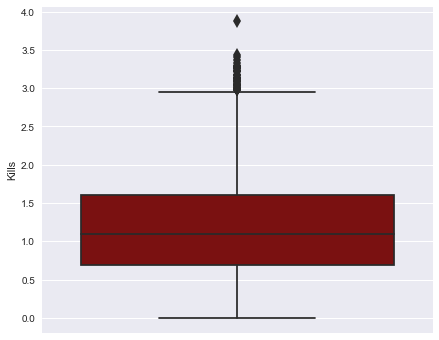

In [84]:
f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(y=np.log(data_nohax['player_kills']),color='darkred',orient='v',fliersize=10)
ax.set(ylabel='Kills');

In [85]:
dbbz = data_nohax[data_nohax['bz_death']==1]
dbbz.drop(['player_survive_time','victim_position_x','victim_position_y','bz_death'],axis=1,inplace=True)
dbbz['sum_coord'] = dbbz['map_x'] + dbbz['map_y']

C:\Users\Jacek\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Jacek\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [86]:
dbbz.head()

killed_by  deaths_PK  ratio_deaths_PK  bz_risk  pktot_ratio        RR  \
47611  Bluezone         82         0.010838      1.0     0.181818  0.001971   
47612  Bluezone         82         0.010838      1.0     0.181818  0.001971   
47613  Bluezone         82         0.010838      1.0     0.181818  0.001971   
47614  Bluezone         82         0.010838      1.0     0.181818  0.001971   
47615  Bluezone         82         0.010838      1.0     0.181818  0.001971   

         log_RR  PK_to_E_deathratio  pkpred_deaths  weap_risk_pk     ...       \
47611 -6.229449            0.004375        33.1018      2.477207     ...        
47612 -6.229449            0.004375        33.1018      2.477207     ...        
47613 -6.229449            0.004375        33.1018      2.477207     ...        
47614 -6.229449            0.004375        33.1018      2.477207     ...        
47615 -6.229449            0.004375        33.1018      2.477207     ...        

       game_size  player_assists  player_dist_walk  player_dmg  player_kills  \
47611         94               0        1287.92285         217             1   
47612         85               0        2300.88574         474             3   
47613         97               0        3639.00537         532             5   
47614         58               0        1088.40356         242             3   
47615         98               0        2736.41479         741             8   

          player_name        map_x        map_y  aggro_factor    sum_coord  
47611          Quziye  1042.318848  2576.701952      2.308511  3619.020800  
47612     fyrentattoo  2699.835392  3450.098688     16.729412  6149.934080  
47613      cuipeng020   765.975040  3054.537728     27.422680  3820.512768  
47614  KRONIK-_-SMOKE  2392.939008  1628.453376     12.517241  4021.392384  
47615    laochou_gazi  1773.472768  2226.229248     60.489796  3999.702016  

[5 rows x 31 columns]

In [87]:
dbow = data_nohax[data_nohax['bz_death']==0]
dbow.drop(['player_survive_time','victim_position_x','victim_position_y','bz_death'],axis=1,inplace=True)
dbow['sum_coord'] = dbow['map_x'] + dbow['map_y']

C:\Users\Jacek\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Jacek\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
data_nohax.drop(['killed_by','player_name','deaths_PK','ratio_deaths_PK'],axis=1,inplace=True)
data_nohax.head()

bz_risk  pktot_ratio        RR   log_RR  PK_to_E_deathratio  \
0  0.390508     0.263858  0.001117 -6.79735            0.004375   
1  0.390508     0.263858  0.001117 -6.79735            0.004375   
2  0.390508     0.263858  0.001117 -6.79735            0.004375   
3  0.390508     0.263858  0.001117 -6.79735            0.004375   
4  0.390508     0.263858  0.001117 -6.79735            0.004375   

   pkpred_deaths  weap_risk_pk  weap_riskreal_pk  deaths_YS  ratio_deaths_YS  \
0     123.013921       0.96737          0.255248        190         0.006757   
1     123.013921       0.96737          0.255248        190         0.006757   
2     123.013921       0.96737          0.255248        190         0.006757   
3     123.013921       0.96737          0.255248        190         0.006757   
4     123.013921       0.96737          0.255248        190         0.006757   

     ...     player_dmg  player_kills  player_survive_time  time  \
0    ...            186             0             1958.794  1959   
1    ...            175             2             1885.232  1885   
2    ...            268             3             1789.011  1789   
3    ...            161             1             1911.150  1911   
4    ...            366             3             1786.770  1787   

   victim_position_x  victim_position_y        map_x        map_y  \
0           371084.5           120010.0  1899.952640   614.451200   
1           505921.5           643210.9  2590.318080  3293.239808   
2           372918.1           647580.1  1909.340672  3315.610112   
3           272015.8           307686.3  1392.720896  1575.353856   
4           587692.4           156271.4  3008.985088   800.109568   

   aggro_factor  bz_death  
0      2.043956         0  
1      5.555556         0  
2      8.375000         0  
3      1.939759         0  
4     12.620690         0  

[5 rows x 31 columns]

In [124]:
data_nohax.columns

Index(['deaths_PK', 'ratio_deaths_PK', 'bz_risk', 'pktot_ratio', 'RR',
       'log_RR', 'PK_to_E_deathratio', 'pkpred_deaths', 'weap_risk_pk',
       'weap_riskreal_pk', 'deaths_YS', 'ratio_deaths_YS', 'ysbz_risk',
       'ystot_ratio', 'ysRR', 'log_ysRR', 'YS_to_E_deathratio',
       'yspred_deaths_ys', 'weap_risk_ys', 'weap_riskreal_ys', 'game_size',
       'player_assists', 'player_dist_walk', 'player_dmg', 'player_kills',
       'player_survive_time', 'victim_position_x', 'victim_position_y',
       'map_x', 'map_y', 'aggro_factor', 'bz_death'],
      dtype='object')

In [ ]:
#pd.plotting.scatter_matrix(dbbz,figsize=(8,8),diagonal='kde',color='#80dfff',alpha=0.2);

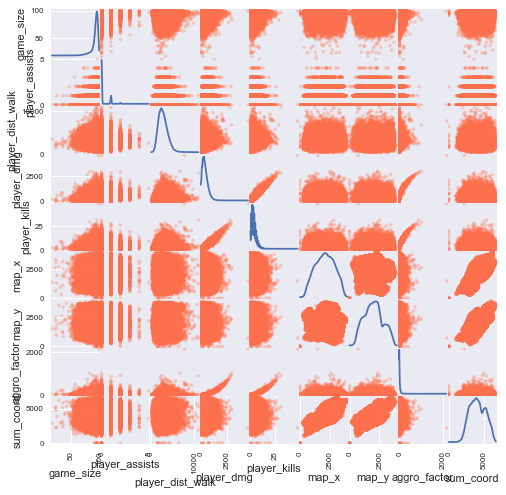

In [376]:
pd.plotting.scatter_matrix(dbow,figsize=(8,8),diagonal='kde',color='#ff704d',alpha=0.3);

In [50]:
data_nohax.columns

Index(['killed_by_x', 'deaths_PK', 'ratio_deaths_PK', 'bz_risk', 'pktot_ratio',
       'RR', 'log_RR', 'PK_to_E_deathratio', 'pkpred_deaths', 'weap_risk_pk',
       'weap_riskreal_pk', 'deaths_YS', 'ratio_deaths_YS', 'ysbz_risk',
       'ystot_ratio', 'ysRR', 'log_ysRR', 'YS_to_E_deathratio',
       'yspred_deaths_ys', 'weap_risk_ys', 'weap_riskreal_ys', 'game_size',
       'player_assists', 'player_dist_walk', 'player_dmg', 'player_kills',
       'player_name', 'player_survive_time', 'killed_by_y', 'time',
       'victim_position_x', 'victim_position_y', 'map_x', 'map_y',
       'aggro_factor', 'bz_death', 'merge', 'bz_city_overall'],
      dtype='object')

In [51]:
#add city deaths
data_nohax['ys_death'] = np.where((data_nohax['map_x'] < 2850) 
                                & (data_nohax['map_x'] > 2600) 
                                & (data_nohax['map_y'] > 1100) 
                                & (data_nohax['map_y'] < 1280), 1, 0)

data_nohax['pk_death'] = np.where((data_nohax['map_x'] > 1750) 
                                  & (data_nohax['map_x'] < 1900) 
                                  & (data_nohax['map_y'] > 1950) 
                                  & (data_nohax['map_y'] < 2100), 1, 0)

data_nohax['gpn_death'] = np.where((data_nohax['map_x'] > 600) 
                                  & (data_nohax['map_x'] < 1100) 
                                  & (data_nohax['map_y'] > 1050) 
                                  & (data_nohax['map_y'] < 1250), 1, 0)

data_nohax['gps_death'] = np.where((data_nohax['map_x'] > 600) 
                                  & (data_nohax['map_x'] < 1100) 
                                  & (data_nohax['map_y'] > 1350) 
                                  & (data_nohax['map_y'] < 1550), 1, 0)

data_nohax['prim_death'] = np.where((data_nohax['map_x'] > 600) 
                                  & (data_nohax['map_x'] < 1000) 
                                  & (data_nohax['map_y'] > 3000) 
                                  & (data_nohax['map_y'] < 3300), 1, 0)

data_nohax['rz_death'] = np.where((data_nohax['map_x'] > 1950) 
                                  & (data_nohax['map_x'] < 2150) 
                                  & (data_nohax['map_y'] > 1350) 
                                  & (data_nohax['map_y'] < 1550), 1, 0)

data_nohax['sv_death'] = np.where((data_nohax['map_x'] > 1850) 
                                  & (data_nohax['map_x'] < 2000) 
                                  & (data_nohax['map_y'] > 350) 
                                  & (data_nohax['map_y'] < 750), 1, 0)

data_nohax['my_death'] = np.where((data_nohax['map_x'] > 2900) 
                                  & (data_nohax['map_x'] < 3150) 
                                  & (data_nohax['map_y'] > 2300) 
                                  & (data_nohax['map_y'] < 2600), 1, 0)

data_nohax['gk_death'] = np.where((data_nohax['map_x'] > 1050) 
                                  & (data_nohax['map_x'] < 1200) 
                                  & (data_nohax['map_y'] > 1900) 
                                  & (data_nohax['map_y'] < 2100), 1, 0)

data_nohax['smb_death'] = np.where((data_nohax['map_x'] > 2000) 
                                  & (data_nohax['map_x'] < 2500) 
                                  & (data_nohax['map_y'] > 3100) 
                                  & (data_nohax['map_y'] < 3400), 1, 0)

data_nohax['nv_death'] = np.where((data_nohax['map_x'] > 3000) 
                                  & (data_nohax['map_x'] < 3200) 
                                  & (data_nohax['map_y'] > 2800) 
                                  & (data_nohax['map_y'] < 3200), 1, 0)

data_nohax['lp_death'] = np.where((data_nohax['map_x'] > 3500) 
                                  & (data_nohax['map_x'] < 3700) 
                                  & (data_nohax['map_y'] > 1550) 
                                  & (data_nohax['map_y'] < 1850), 1, 0)

data_nohax['mp_death'] = np.where((data_nohax['map_x'] > 3550) 
                                  & (data_nohax['map_x'] < 3850) 
                                  & (data_nohax['map_y'] > 2050) 
                                  & (data_nohax['map_y'] < 2400), 1, 0)

data_nohax['bz_death_city'] = np.where(((data_nohax['ys_death'] == 1) 
                                       | (data_nohax['pk_death'] == 1)
                                       | (data_nohax['pk_death'] == 1)
                                       | (data_nohax['gpn_death'] == 1)
                                       | (data_nohax['gps_death'] == 1)
                                       | (data_nohax['prim_death'] == 1)
                                       | (data_nohax['rz_death'] == 1)
                                       | (data_nohax['sv_death'] == 1)
                                       | (data_nohax['my_death'] == 1)
                                       | (data_nohax['gk_death'] == 1)
                                       | (data_nohax['smb_death'] == 1)
                                       | (data_nohax['nv_death'] == 1)
                                       | (data_nohax['lp_death'] == 1)
                                       | (data_nohax['mp_death'] == 1)                                       
                                       ) & (data_nohax['bz_death'] == 1),1,0)

In [52]:
data_nohax['bz_death_city'].nunique()

2

In [53]:
data_nohax['bz_death_city'].describe()

count    102946.000000
mean          0.010656
std           0.102677
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: bz_death_city, dtype: float64

In [94]:
aggro_factor_mean = data_nohax.aggro_factor.mean()
aggro_factor_mean

24.094567127181403

### We are going to see if we can predict that a death happend in the bluezone. Success should be something well over 15% of the time...

In [108]:
data_nohax['aggfac_sub_mean'] = np.where((data_nohax['aggro_factor'] < aggro_factor_mean),1,0)
data_nohax['lowmean_bzcity'] = np.where((data_nohax['aggfac_sub_mean'] ==1) & (data_nohax['bz_death_city']==1),1,0)


In [109]:
data_nohax.columns

Index(['killed_by_x', 'deaths_PK', 'ratio_deaths_PK', 'bz_risk', 'pktot_ratio',
       'RR', 'log_RR', 'PK_to_E_deathratio', 'pkpred_deaths', 'weap_risk_pk',
       'weap_riskreal_pk', 'deaths_YS', 'ratio_deaths_YS', 'ysbz_risk',
       'ystot_ratio', 'ysRR', 'log_ysRR', 'YS_to_E_deathratio',
       'yspred_deaths_ys', 'weap_risk_ys', 'weap_riskreal_ys', 'game_size',
       'player_assists', 'player_dist_walk', 'player_dmg', 'player_kills',
       'player_name', 'player_survive_time', 'killed_by_y', 'time',
       'victim_position_x', 'victim_position_y', 'map_x', 'map_y',
       'aggro_factor', 'bz_death', 'merge', 'bz_city_overall', 'ys_death',
       'pk_death', 'gpn_death', 'gps_death', 'prim_death', 'rz_death',
       'sv_death', 'my_death', 'gk_death', 'smb_death', 'nv_death', 'lp_death',
       'mp_death', 'bz_death_city', 'aggfac_sub_mean', 'lowmean_bzcity'],
      dtype='object')

In [118]:
predict_data = data_nohax.drop(['victim_position_x','victim_position_y','merge','killed_by_x','killed_by_y','player_name'],axis=1)
predict_data['is_train'] = np.random.uniform(0, 1, len(predict_data)) <= .75
train, test = predict_data[predict_data['is_train']==True], predict_data[predict_data['is_train']==False]
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 77131
Number of observations in the test data: 25815


In [119]:
predict_data.columns

Index(['deaths_PK', 'ratio_deaths_PK', 'bz_risk', 'pktot_ratio', 'RR',
       'log_RR', 'PK_to_E_deathratio', 'pkpred_deaths', 'weap_risk_pk',
       'weap_riskreal_pk', 'deaths_YS', 'ratio_deaths_YS', 'ysbz_risk',
       'ystot_ratio', 'ysRR', 'log_ysRR', 'YS_to_E_deathratio',
       'yspred_deaths_ys', 'weap_risk_ys', 'weap_riskreal_ys', 'game_size',
       'player_assists', 'player_dist_walk', 'player_dmg', 'player_kills',
       'player_survive_time', 'time', 'map_x', 'map_y', 'aggro_factor',
       'bz_death', 'bz_city_overall', 'ys_death', 'pk_death', 'gpn_death',
       'gps_death', 'prim_death', 'rz_death', 'sv_death', 'my_death',
       'gk_death', 'smb_death', 'nv_death', 'lp_death', 'mp_death',
       'bz_death_city', 'aggfac_sub_mean', 'lowmean_bzcity', 'is_train'],
      dtype='object')

In [68]:
test.bz_death.head()

1     1
12    0
13    0
15    0
17    0
Name: bz_death, dtype: int32

In [120]:
features = train.columns[:45]
features

Index(['deaths_PK', 'ratio_deaths_PK', 'bz_risk', 'pktot_ratio', 'RR',
       'log_RR', 'PK_to_E_deathratio', 'pkpred_deaths', 'weap_risk_pk',
       'weap_riskreal_pk', 'deaths_YS', 'ratio_deaths_YS', 'ysbz_risk',
       'ystot_ratio', 'ysRR', 'log_ysRR', 'YS_to_E_deathratio',
       'yspred_deaths_ys', 'weap_risk_ys', 'weap_riskreal_ys', 'game_size',
       'player_assists', 'player_dist_walk', 'player_dmg', 'player_kills',
       'player_survive_time', 'time', 'map_x', 'map_y', 'aggro_factor',
       'bz_death', 'bz_city_overall', 'ys_death', 'pk_death', 'gpn_death',
       'gps_death', 'prim_death', 'rz_death', 'sv_death', 'my_death',
       'gk_death', 'smb_death', 'nv_death', 'lp_death', 'mp_death'],
      dtype='object')

Let's start with KMeans Clustering on data from all match deaths.

In [ ]:
#let's see if the list of factors we're looking at will help us predict whether an individual dies by bluezone (bz_death == 1)!

In [32]:
from sklearn.cluster import KMeans

In [394]:
'''#From our earlier analysis we know that these coordinates from the cities:
#(xmin,xmax,ymin,ymax)
Georgopol = 
Mylta = 
Pochinki = (1750,1900,1950,2100)
Yasnaya_Polyana = 

[(qs[:,0] > 1750) & (qs[:,0] < 1900) & (qs[:,1] > 1950) & (qs[:,1] < 2100)]
second_place_deaths = np.vstack(df1[['victim_position_x','victim_position_y']].values)''';

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

y = train['lowmean_bzcity']

clf = RandomForestClassifier(n_jobs=1000, random_state=100,n_estimators=3)
clf.fit(train[features], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=1000,
            oob_score=False, random_state=100, verbose=0, warm_start=False)

In [122]:
clf.predict(test[features])

array([0, 0, 0, ..., 0, 0, 0])

In [123]:
test.head()

deaths_PK  ratio_deaths_PK  bz_risk  pktot_ratio        RR    log_RR  \
1          82         0.010838      1.0     0.181818  0.001971 -6.229449   
4          82         0.010838      1.0     0.181818  0.001971 -6.229449   
16         82         0.010838      1.0     0.181818  0.001971 -6.229449   
17         82         0.010838      1.0     0.181818  0.001971 -6.229449   
19         82         0.010838      1.0     0.181818  0.001971 -6.229449   

    PK_to_E_deathratio  pkpred_deaths  weap_risk_pk  weap_riskreal_pk  \
1             0.004375        33.1018      2.477207          0.450401   
4             0.004375        33.1018      2.477207          0.450401   
16            0.004375        33.1018      2.477207          0.450401   
17            0.004375        33.1018      2.477207          0.450401   
19            0.004375        33.1018      2.477207          0.450401   

      ...     my_death  gk_death  smb_death  nv_death  lp_death  mp_death  \
1     ...            0         0          0         0         0         0   
4     ...            0         0          0         0         0         0   
16    ...            0         0          0         0         0         0   
17    ...            0         0          0         0         0         0   
19    ...            0         0          0         0         0         0   

    bz_death_city  aggfac_sub_mean  lowmean_bzcity  is_train  
1               0                1               0     False  
4               0                1               0     False  
16              0                1               0     False  
17              0                1               0     False  
19              0                0               0     False  

[5 rows x 49 columns]

In [124]:
import time
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier

pd.crosstab(test['bz_death_city'], clf.predict(test[features]))

col_0              0    1
bz_death_city            
0              25530    9
1                105  171

## Working with an additional variable

In [396]:
#Not really all that great for this dataset. What about death by bluezone in Pochinki??
#Pochinki = (1750,1900,1950,2100)
predict_data['bz_pochinki'] = np.where((predict_data['map_x'] > 1750) & 
                                       (predict_data['map_x'] < 1900) &
                                       (predict_data['map_y'] > 1950) &
                                       (predict_data['map_y'] < 2100), 1, 0)
predict_data2 = predict_data.copy()
predict_data2.drop(['map_x','map_y'],axis=1,inplace=True)
predict_data2.head()

game_size  player_assists  player_dist_walk  player_dmg  player_kills  \
0         91               1        1813.36450         186             0   
1         94               0        1287.92285         217             1   
2         95               0        2403.10352          52             0   
3         63               0        4033.27979         175             2   
4         85               0        2300.88574         474             3   

   player_survive_time  bz_death  is_train  bz_pochinki  
0             1958.794         0      True            0  
1             1883.838         1      True            0  
2             1881.415         0      True            0  
3             1885.232         0      True            0  
4             1875.549         1      True            0

In [397]:
predict_data2[predict_data2['bz_pochinki'] == 1].count()

game_size              448
player_assists         448
player_dist_walk       448
player_dmg             448
player_kills           448
player_survive_time    448
bz_death               448
is_train               448
bz_pochinki            448
dtype: int64

In [390]:
train2, test2 = [predict_data2['is_train']==True], predict_data2[predict_data2['is_train']==False]
print('Number of observations in the training data:', len(train2))
print('Number of observations in the test data:',len(test2))

Number of observations in the training data: 77375
Number of observations in the test data: 25571


In [391]:
features2 = train2.columns[:8]
features2

Index(['game_size', 'player_assists', 'player_dist_walk', 'player_dmg',
       'player_kills', 'player_survive_time', 'bz_death', 'is_train'],
      dtype='object')

In [392]:
train2, test2 = predict_data2[predict_data2['is_train']==True], predict_data2[predict_data2['is_train']==False]
print('Number of observations in the training data:', len(train2))
print('Number of observations in the test data:',len(test2))

Number of observations in the training data: 77375
Number of observations in the test data: 25571


In [402]:
y2 = train2['bz_pochinki']

clf = RandomForestClassifier(n_jobs=10000, random_state=1000,n_estimators=6)
clf.fit(train2[features2], y2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=10000,
            oob_score=False, random_state=1000, verbose=0,
            warm_start=False)

In [403]:
pd.crosstab(test2['bz_pochinki'], clf.predict(test2[features2]))


col_0            0  1
bz_pochinki          
0            25438  1
1              132  0

well, shit...

T-sne?

In [78]:
%pylab inline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

Populating the interactive namespace from numpy and matplotlib


C:\Users\Jacek\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [126]:
predict_data.head()
predict_tsne = predict_data.drop([('is_train')],axis=1)
predict_tsne.head()

deaths_PK  ratio_deaths_PK  bz_risk  pktot_ratio        RR    log_RR  \
0         82         0.010838      1.0     0.181818  0.001971 -6.229449   
1         82         0.010838      1.0     0.181818  0.001971 -6.229449   
2         82         0.010838      1.0     0.181818  0.001971 -6.229449   
3         82         0.010838      1.0     0.181818  0.001971 -6.229449   
4         82         0.010838      1.0     0.181818  0.001971 -6.229449   

   PK_to_E_deathratio  pkpred_deaths  weap_risk_pk  weap_riskreal_pk  \
0            0.004375        33.1018      2.477207          0.450401   
1            0.004375        33.1018      2.477207          0.450401   
2            0.004375        33.1018      2.477207          0.450401   
3            0.004375        33.1018      2.477207          0.450401   
4            0.004375        33.1018      2.477207          0.450401   

        ...        sv_death  my_death  gk_death  smb_death  nv_death  \
0       ...               1         0         0          0         0   
1       ...               0         0         0          0         0   
2       ...               0         0         0          0         0   
3       ...               0         0         0          0         0   
4       ...               0         0         0          0         0   

   lp_death  mp_death  bz_death_city  aggfac_sub_mean  lowmean_bzcity  
0         0         0              0                1               0  
1         0         0              0                1               0  
2         0         0              0                1               0  
3         0         0              0                1               0  
4         0         0              0                1               0  

[5 rows x 48 columns]

In [ ]:
predict_tsne[predict_tsne['']]

In [127]:
X_tsne = TSNE(learning_rate=1000,perplexity=20).fit_transform(predict_data.head(30000))
X_pca = PCA().fit_transform(predict_data.head(30000))

In [76]:
predict_data.columns

Index(['deaths_PK', 'ratio_deaths_PK', 'bz_risk', 'pktot_ratio', 'RR',
       'log_RR', 'PK_to_E_deathratio', 'pkpred_deaths', 'weap_risk_pk',
       'weap_riskreal_pk', 'deaths_YS', 'ratio_deaths_YS', 'ysbz_risk',
       'ystot_ratio', 'ysRR', 'log_ysRR', 'YS_to_E_deathratio',
       'yspred_deaths_ys', 'weap_risk_ys', 'weap_riskreal_ys', 'game_size',
       'player_assists', 'player_dist_walk', 'player_dmg', 'player_kills',
       'player_survive_time', 'time', 'map_x', 'map_y', 'aggro_factor',
       'bz_death', 'bz_city_overall', 'ys_death', 'pk_death', 'gpn_death',
       'gps_death', 'prim_death', 'rz_death', 'sv_death', 'my_death',
       'gk_death', 'smb_death', 'nv_death', 'lp_death', 'mp_death',
       'bz_death_city', 'is_train'],
      dtype='object')

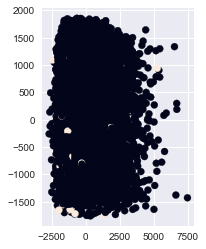

In [129]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=predict_data.lowmean_bzcity.head(30000))
subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict_data.lowmean_bzcity.head(30000))

In [84]:
data_nohax.columns

Index(['killed_by_x', 'deaths_PK', 'ratio_deaths_PK', 'bz_risk', 'pktot_ratio',
       'RR', 'log_RR', 'PK_to_E_deathratio', 'pkpred_deaths', 'weap_risk_pk',
       'weap_riskreal_pk', 'deaths_YS', 'ratio_deaths_YS', 'ysbz_risk',
       'ystot_ratio', 'ysRR', 'log_ysRR', 'YS_to_E_deathratio',
       'yspred_deaths_ys', 'weap_risk_ys', 'weap_riskreal_ys', 'game_size',
       'player_assists', 'player_dist_walk', 'player_dmg', 'player_kills',
       'player_name', 'player_survive_time', 'killed_by_y', 'time',
       'victim_position_x', 'victim_position_y', 'map_x', 'map_y',
       'aggro_factor', 'bz_death', 'merge', 'bz_city_overall', 'ys_death',
       'pk_death', 'gpn_death', 'gps_death', 'prim_death', 'rz_death',
       'sv_death', 'my_death', 'gk_death', 'smb_death', 'nv_death', 'lp_death',
       'mp_death', 'bz_death_city'],
      dtype='object')

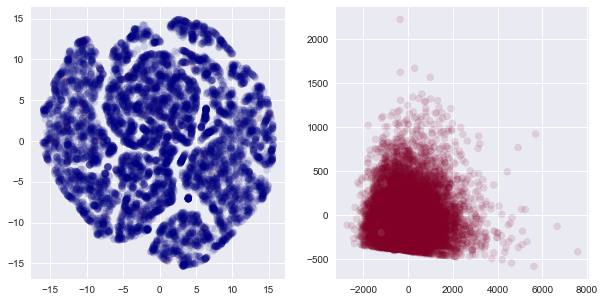

In [433]:
figure(figsize=(10, 5))
subplot(121)
scatter(X_tsne[:, 0], X_tsne[:, 1], c=predict_data2.bz_pochinki.head(10000),cmap='jet',alpha=0.12)
subplot(122)
scatter(X_pca[:, 0], X_pca[:, 1], c=predict_data2.bz_pochinki.head(10000),cmap=('YlOrRd_r'),alpha=0.12)

In [149]:
predict_data_pochinki.columns

NameError: name 'predict_data_pochinki' is not defined

In [150]:
#Let's look ONLY at deaths in pochinki. there's too much going on otherwise :(

predict_data['pochinki'] = predict_data['bz_pochinki'] = np.where((predict_data['map_x'] > 1750) & 
                                       (predict_data['map_x'] < 1900) &
                                       (predict_data['map_y'] > 1950) &
                                       (predict_data['map_y'] < 2100), 1, 0)
predict_data.head()
predict_data_pochinki = predict_data[predict_data['pochinki']==1]
predict_data_pochinki.shape
predict_data_pochinki.drop(['map_x','map_y','is_train','game_size'],axis=1,inplace=True)

C:\Users\Jacek\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [451]:
predict_data_pochinki.columns

Index(['player_assists', 'player_dist_walk', 'player_dmg', 'player_kills',
       'player_survive_time', 'bz_death', 'bz_pochinki', 'pochinki'],
      dtype='object')

In [177]:
X_tsne = TSNE(learning_rate=15,n_iter=1300,perplexity=40,early_exaggeration=10).fit_transform(predict_data_pochinki)
X_pca = PCA().fit_transform(predict_data_pochinki)

In [178]:
figure(figsize=(10, 5))
subplot(121)
scatter(X_tsne[:, 0], X_tsne[:, 1], c=predict_data_pochinki.bz_death,cmap='prism',alpha=0.7)
subplot(122)
scatter(X_pca[:, 0], X_pca[:, 1], c=predict_data_pochinki.bz_death,cmap='prism',alpha=0.7)

In [474]:
predict_data_pochinki.pochinki.nunique()

1

In [484]:
figure(figsize=(10, 5))
subplot(121)
scatter(X_tsne[:, 0], X_tsne[:, 1], c=predict_data_pochinki.bz_death,cmap='prism',alpha=0.7)
subplot(122)
scatter(X_pca[:, 0], X_pca[:, 1], c=predict_data_pochinki.bz_death,cmap='prism',alpha=0.7)

In [485]:
X_tsne = TSNE(learning_rate=1000,perplexity=5,).fit_transform(predict_data)
X_pca = PCA().fit_transform(predict_data)

In [494]:
figure(figsize=(10, 5))
subplot(121)
scatter(X_tsne[:, 0], X_tsne[:, 1], c=predict_data['bz_pochinki']==0,cmap='cubehelix',alpha=0.3)
subplot(122)
scatter(X_pca[:, 0], X_pca[:, 1], c=predict_data['bz_pochinki']==0,cmap='prism')

In [416]:
figure(figsize=(10, 5))
subplot(121)
scatter(X_tsne[:, 0], X_tsne[:, 1], c=iris.target,cmap='prism')
subplot(122)
scatter(X_pca[:, 0], X_pca[:, 1], c=iris.target,cmap='prism')

In [395]:
import xgboost as xgb


In [ ]:
#AH! I forgot to set a new column for BZ death in either city!!!
predict_data['is_bz_city'] = np.where([predict_data['bz_pochinki'] | [predict_data['killed_by'] == 'Bluezone', 1, 0)

In [190]:
predict_data.columns

Index(['deaths_PK', 'ratio_deaths_PK', 'bz_risk', 'pktot_ratio', 'RR',
       'log_RR', 'PK_to_E_deathratio', 'pkpred_deaths', 'weap_risk_pk',
       'weap_riskreal_pk', 'deaths_YS', 'ratio_deaths_YS', 'ysbz_risk',
       'ystot_ratio', 'ysRR', 'log_ysRR', 'YS_to_E_deathratio',
       'yspred_deaths_ys', 'weap_risk_ys', 'weap_riskreal_ys', 'game_size',
       'player_assists', 'player_dist_walk', 'player_dmg', 'player_kills',
       'player_survive_time', 'map_x', 'map_y', 'aggro_factor', 'bz_death',
       'is_train', 'pochinki', 'bz_pochinki'],
      dtype='object')

In [189]:

import xgboost as xgb
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedKFold
import random

import pdb

arm = predict_data.aggro_ratio.mean()  #aggro ratio mean


directory = 'C:/Users/Jacek/Documents/GA/dat-2017-11-14/lessons/lesson-13/input/'
train_input = predict_data


bins = [0, 20, 30, 40,50,60,70,80,90,120]
class Bagging(BaseEstimator):
    
    def __init__(self, models, bag_size):
        assert bag_size > 0.0 and bag_size <= 1.0
        self.models = models
        self.bag_size = bag_size
        
    def fit(self, X, y):
        N = X.shape[0]
        for model in self.models:
            bag_indices = np.random.randint(0, N, int(N*self.bag_size))
            model.fit(X[bag_indices], y[bag_indices])
        return self
    
    def classes_(self):
      return self.models[0].classes_

    def predict_proba(self, X):
        return np.mean([m.predict_proba(X) for m in self.models], axis=0)

    def predict(self, X):
        return self.predict_proba(self, X) > 1

class CreditScoreFeaturizer():
  def __init__(self):
    pass
  
  def fit_transform(self, dataset):
    """
      Transform a datframe <dataset> into a feature matrix

      params:
      dataset : Pandas DataFrame, the input dataset

      Returns a matrix N samples x M features
    """

    ###First step, select some fields we care about, all of these are numeric, so we can just pick them out
    dataset['binage'] = pd.cut(dataset.age,bins)
    mean_age_income = dataset.groupby('binage').MonthlyIncome.mean()
    dataset.binage = dataset.binage.combine_first(dataset.binage.map(mean_age_income))
    dataset['log_dollar_per_year'] = np.log(dataset['MonthlyIncome']*12)
    dataset.drop(dataset['NumberOfTimes90DaysLate'] > 20)
    dataset.drop(dataset['DebtRatio'] > 10)
    dataset.drop((dataset['SeriousDlqin2yrs'] == 0) & (dataset['RevolvingUtilizationOfUnsecuredLines'] == 0) & (dataset['DebtRatio'] == 0))
    #dataset.loc[dataset['NumberOfTimes90DaysLate'] > 20, 'NumberOfTimes90DaysLate'] = dataset[dataset['NumberOfTimes90DaysLate'] < 20].mean()
    #dataset['modcred'] = dataset[dataset['NumberOfOpenCreditLinesAndLoans'] > 20].apply(dataset['NumberOfOpenCreditLinesAndLoans'].mean())
    #dataset['agewithkids'] = (dataset['NumberOfDependents'] / dataset['age']) * dataset['dollar_per_year']
    #dataset['logdebt'] = np.log(dataset['DebtRatio'])
    dataset['risky'] = ((dataset['NumberOfDependents'] * dataset['NumberOfOpenCreditLinesAndLoans']) / dataset['age'])
    dataset.loc[dataset['NumberOfOpenCreditLinesAndLoans'] == 0, 'NumberOfOpenCreditLinesAndLoans'] == 1
    #dataset['openlines'] = dataset[dataset['NumberOfOpenCreditLinesAndLoans'] == 0].apply(dataset['NumberOfOpenCreditLinesAndLoans'] == 1)
    #data = np.array(dataset[[ 'age', 'risky','log_dollar_per_year','NumberOfTimes90DaysLate','DebtRatio','NumberOfOpenCreditLinesAndLoans']])
    data = np.array(dataset[[ 'age', 'MonthlyIncome','NumberOfTimes90DaysLate','NumberOfDependents','DebtRatio','NumberOfOpenCreditLinesAndLoans','RevolvingUtilizationOfUnsecuredLines','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTime30-59DaysPastDueNotWorse','NumberRealEstateLoansOrLines']])
    # ## You want to perform some more interesting transformations of the data
    # ## For example, ratios
    # dataset['dollar_per_year'] = dataset['MonthlyIncome'] / dataset['age']

    ## One preprocesing step we will need to perform is imputation, fill in missing values
    imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
    data = imputer.fit_transform(data)

    #return np.hstack([data])

    # Scaling features may be important you have very large outliers or need more intepretable coefficients
    scaler = preprocessing.StandardScaler()
    scaled_income = scaler.fit_transform([data[:,1]])

    data =  np.hstack([data, scaled_income.reshape(len(data), 1)])

    ## Turning features into discrete features is important if you are using linear classifier, but the underlying 
    ## data does not have a linear relationship

    # NOTE: the binarizer, turns everything > 0 to 1 and and everything less than 0 to 0, so use the StandardScaler first
    binarizer = preprocessing.Binarizer()
    binned_income = binarizer.fit_transform(scaled_income)

    data =  np.hstack( [data, binned_income.reshape(len(data), 1)] )

    return data


def create_submission(model, X_test, test_df):
  predictions = pd.Series(x[1] for x in model.predict_proba(X_test))

  submission = pd.DataFrame({'Id': test_df['Id'], 'Probability': predictions})
  submission.sort_index(axis=1, inplace=True)
  submission.to_csv('submission.csv', index=False)

def main():
  train_input = pd.read_csv(directory + 'train.csv')
  test_input = pd.read_csv(directory + 'test.csv')
  data = pd.concat([train_input, test_input])
  #train_input = train_input.dropna(axis=1, how='any')

  featurizer = CreditScoreFeaturizer()
  
  print ("Transforming dataset into features...")
  ##Create matrix of features from raw dataset
  X = featurizer.fit_transform(data)
  X_train = X[:len(train_input)]
  X_test = X[len(train_input):]

  ## Use any model that we might find appropriate
  #model = RidgeClassifierCV(alphas=[ 0.1, 1., 10. ])

  # Bagging Example
  n_models=2
  bag_size=1
    
  ##Classifiers
  clf1 = LogisticRegression(C=2)
  clf2 = RandomForestClassifier(n_estimators=5)
  clf3 = GaussianNB()
  clf4 = GradientBoostingClassifier(n_estimators=2,max_depth=10)
  clf5 = Bagging((clf1,
                                       clf2,
                                       clf3,clf4,
                                       ),bag_size)
  clf6 = xgb.XGBClassifier(n_estimators=2,max_depth=10)
    
  ##Create the object and set relevant parameters
  #model = LogisticRegression(C=10)

  ##Set target variable y
  y = train_input.SeriousDlqin2yrs


  model = VotingClassifier(estimators=[('lr', clf1),
                                       ('rf', clf2),
                                       ('gnb',clf3),
                                       ('gbc',clf4),
                                       ('xfg',clf6),
                                       ('bag',clf5)],
                                       voting='soft')
  #models = [LogisticRegression(C=10), RandomForestClassifier(n_estimators=100)]
  #model = Bagging(models, bag_size)

  #pdb.set_trace()
  print ("Cross validating...")
  print (np.mean(cross_val_score(model, X_train, y.values, scoring='roc_auc', cv=10)))

  print ("Training final model...")
  model = model.fit(X_train, y)


  print ("Create predictions on submission set and export to .csv...")
  create_submission(model, X_test, test_input)

if __name__ == '__main__':
  main()

NameError: name 'iris' is not defined